In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

ee.Initialize()

%load_ext autoreload
%autoreload 2

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numba/core/decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - monthly SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_inflow(stid, startdate, enddate):
    '''
    Fetch the daily reservoir inflow for a CDEC reservoir ID
    Input: stid (str) - 3 letter station id (ex: ISB)
    Output: Sres - (pd.DataFrame) - the full monthly flow (km^3 / mon)
    '''
    # Download Storage (SensorNums = 65) data by query str:
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    url = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=76&dur_code=D&Start=2000-01-01&End=2020-01-01'''.format(stid)
    print(url)
    urlData = requests.get(url).content
    df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    inflow = pd.to_numeric(df.VALUE, errors='coerce')
    indf = pd.DataFrame(zip(dt_idx,inflow* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return rs.col_to_dt(indf)


def df_shifted(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

def get_error_stats(preds,obs):
    
    A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

    solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
    m, c = solution[0]
    residuals = solution[1]

    # Calc RMSE 
    rmse = float(np.sqrt(np.mean((obs - preds)**2)))
    print(rmse)

    # Calc R^2    
    r2 = float(1 - residuals / sum((obs - obs.mean())**2))

    # Calc ubRMSE
    ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

    # Calc Bias 
    bias = float(np.mean(obs - preds))
    
    print(r2, rmse,ubrmse,bias)
    
    return [rmse, r2, ubrmse, bias, m, c,]

def make_plots(preds,obs):
    
    A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T

    solution = np.linalg.lstsq(A, obs.reshape(len(obs),1))
    m, c = solution[0]
    residuals = solution[1]
    r2 = 1 - residuals / sum((obs - obs.mean())**2) 

    # Calc RMSE 
    nn_rmse = float(np.sqrt(np.mean((obs - preds)**2)))

    # Calc R^2
    A = np.vstack([preds.reshape(preds.shape[0]), np.ones(len(preds.reshape(preds.shape[0])))]).T
    solution = np.linalg.lstsq(A, obs)
    m, c = solution[0]
    residuals = solution[1]
    nn_r2 = float(1 - residuals / sum((obs - obs.mean())**2))

    # Calc ubRMSE
    ubrmse = float(np.sqrt(np.mean(((obs - np.mean(obs)) - (preds - np.mean(preds)))**2)))

    # Calc Bias 
    bias = float(np.mean(obs - preds))

    plt.scatter(preds, obs, edgecolors='b', alpha =0.5)
    plt.plot(preds, m*preds + c, 'r', label='y = {}x + {}'.format(str(round(m,2)), str(round(c,2))))
    plt.plot([-10, 1e3], [-10, 1e3], "gray", label = "1-1 line")
    plt.title(''' N Samp = {}
                test set RMSE = {}
                test set $R^2$ = {}
                test set ubrmse = {}
                test set bias = {}

                '''.format(len(preds), round(nn_rmse,2), round(nn_r2,4), round(ubrmse,3), round(bias,3)))

    plt.xlabel("predicted")
    plt.ylabel("observed")
    plt.ylim([0,np.max(obs)])
    plt.xlim([0,np.max(preds)])
    plt.legend()
    plt.show()
    
def run_rf(mldf, target = 'q_cms'):

    # Run the Random Forest
    labels = np.array(mldf[target])
    feature_list = list(mldf.columns)
    features = np.array(mldf.drop(target, axis = 1))

    train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size = 0.15, random_state = 42)

    print(len(train_X), len(test_X), len(train_y), len(test_y))
    
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    rf.fit(train_X, train_y);

    predictions = rf.predict(test_X)
    errors = abs(predictions - test_y)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'cms')

    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 9)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]];

    preds = predictions.copy()
    obs = test_y.copy()

    make_plots(preds,obs)


In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '2003-09-30'
enddate = '2020-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

outdir = "../rasters/TE_MI"

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

0
************************************************************
ENG YUBA R


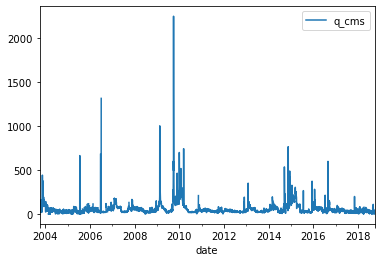

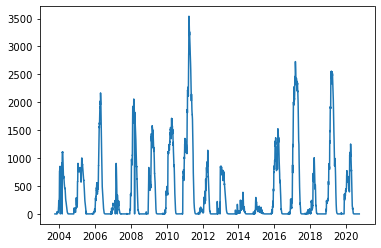

In [ ]:
for idx, x in enumerate(gdf[:1].iterrows()):
    print(idx)
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    catch_shp = "../shape/{}.shp".format(stn_id)
    print(stn_id, row['catch_name'])

    # Get the daily reservoir inflow
    outfn = os.path.join('../data/{}_res.csv'.format(stn_id))
    if not os.path.exists(outfn):
        try:
            inflow = get_res_inflow(stn_id, startdate, enddate)
            inflow[inflow<0] = 0
            inflow.plot()
            inflow.to_csv(outfn)
            plt.show()
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(outfn))
        inflow[inflow<0] = 0
        inflow.plot()
        plt.show()
        
        
    # Get the SWE
    swestack_fn = os.path.join('../data/{}_swe.npy'.format(stn_id))
    if not os.path.exists(swestack_fn):
        swe = get_snodas_swe(catch_shp, startdate, enddate)
        swevals = swe.values()
        swestack = np.dstack(list(swe.values()))
        np.save(swestack_fn, swestack)
    else:
        swestack = np.load(swestack_fn)
        swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]
        
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)
    plt.plot(dt_idx, [np.nansum(x) for x in swevals])
    plt.show()
    
    # Format for pxlwise xcorr 
    
    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []
    
    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(ts_arr)
                rclist.append([row,col])

    # Make df from pixelwise timeseries
    pxdf = pd.DataFrame(px_ts).T
    pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # drop nans
#     tedf = mdf.dropna()
    target = mdf['q_cms']
    mdf.drop(['q_cms'], axis =1 , inplace = True)
    
    # Build the out image
    teim = np.zeros_like(np.mean(swestack, axis = 2))

    # Compute and compile the transfer entropies 
    tedict = {}
        
    for pxidx in tqdm(mdf.columns[:]):
        
        ind_var = mdf[[pxidx]].values
        depvar = target.values

        try:
            TE = PyIF.te_compute.te_compute(tedf['q_cms'].values, tedf[pxidx].values)
        except:
            TE = 0
        
        tedict[pxidx] = [TE]
        
    tedf = pd.DataFrame.from_dict(tedict)
    
    # Populate the per-pixel TE 
    for rc, dfcolidx in zip(rclist,tedf.columns):

        rowidx, colidx = rc
        val = tedf[dfcolidx].values[0]
        teim[rowidx,colidx] = val
    
    plt.imshow(teim)
    plt.colorbar()
    
    # Write
    
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    tefn = os.path.join(outdir,"{}_TE.tif".format(stn_id))
    rs.write_raster(teim, gp.read_file(catch_shp), tefn)
    
    